# Laboratorio Consultas:

#Objetivos

1. Entender el funcionamiento de una red convolucional, en especial, la arquitectura VGG-16.
2. Cargar los datos desde una base de datos Google Drive.
3. Crear un `Dataset` utilizando `ImageFolder`.
4. Entrenar las imágenes utilizando VGG16.
5. Aplicar los conceptos vistos en clases para entrenar una red ResNet.
6. Comparar los resultados obtenidos entre la red VGG y ResNet.
7. Proponer una red neuronal convolucional y comparar resultados.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/COQ-ESC-UCN/Classes/DeepLearning/UAI-1-2022/Lab/S4. Deep Learning II'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/COQ-ESC-UCN/Classes/DeepLearning/UAI-1-2022/Lab/S4. Deep Learning II


## 1. Cargar las librerías

In [ ]:
import torch # Cualquier librería pytorch
import torchvision # Cualquier librería pytorch
from torchvision import transforms, datasets  # Módulos para transformar imágenes a tensores y carga de dataset
import PIL # Librería para manipular imágenes en Python
import time # Librería para medir el tiempo
import copy # Librería para copiar estructuras de datos
from torch.optim import lr_scheduler # Librería para controlar el termino
import torchvision.models as models # Librería para cargar modelos de redes neuronales

## 2. Cargar imágenes

Se cargan las imágenes utilizando la clase **ImageFolder**. La clase ImageForder etiqueta automáticamente las imágenes dada una ruta donde se encuentran los datos. Por ejemplo, si tengo el directorio raíz dataset/training_set. Debo dejar mis imágenes de cada clase en una carpeta diferente. Si tengo imágenes de gatos debo dejarlos en dataset/training_set/cats, si tengo imágenes de perros las debo dejar en dataset/training_set/dogs, etc.

## 4. Separando la base de datos

Para realizar el entrenamiento y pruebas se recomienda separar los datos en tres conjuntos:

* **Conjunto de entrenamiento:** El modelo aprende de los ejemplos de este conjunto de datos. Se ajusta un parámetro a un clasificador.
* **Conjunto de validación:** Los ejemplos en el conjunto de datos de validación se utilizan para ajustar los hiperparámetros, como la tasa de aprendizaje y las épocas. El objetivo de crear un conjunto de validación es evitar un sobreajuste grande del modelo. Es un punto de control para saber si el modelo se ajusta bien con el conjunto de datos de entrenamiento.
* **Conjunto de pruebas:** Este conjunto de datos prueba la evolución final del modelo, midiendo qué tan bien aprendió y predijo el resultado deseado. Contiene datos invisibles de la vida real. Es un conjunto diferente al de entrenamiento y validación.

Imagen: [https://i.imgur.com/DV80uhS.png](https://i.imgur.com/DV80uhS.png)

In [ ]:
# Transformaciones sobre las imágenes
data_transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1),
                                scale=None, shear=None,
                                resample=False, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

data_transform_sin_modificar = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='training_set',
                                           transform=data_transform_train)
gatos_perros_valid = datasets.ImageFolder(root='valid_set',
                                           transform=data_transform_sin_modificar)
gatos_perros_test = datasets.ImageFolder(root='test_set',
                                           transform=data_transform_sin_modificar)

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=32, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)
# Diccionario que almacena el DataLoarder de entrenaminto y validación
dataloaders = {'train': train_loader,
               'val': valid_loader}
dataset_sizes = {'train': len(gatos_perros_train),
                 'val': len(gatos_perros_valid)}

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1376: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


## 3. Visualizo las imágenes cargadas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


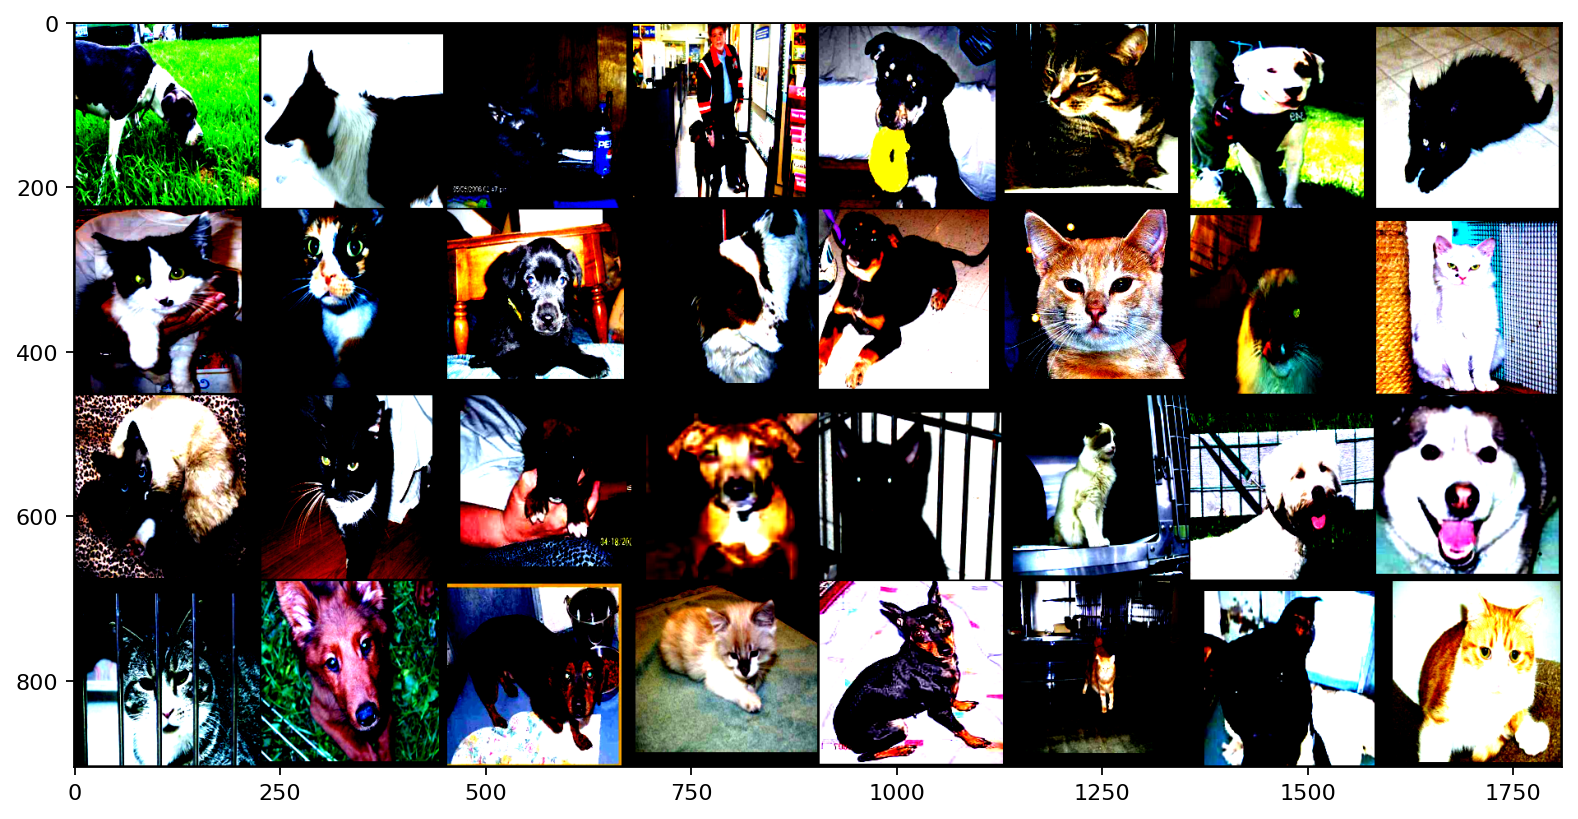

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Obtener imagenes
data_iter = iter(train_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

In [ ]:
print(list(train_loader.sampler))

[1723, 355, 841, 1885, 4394, 3169, 1590, 5377, 405, 791, 3145, 4637, 5637, 1465, 153, 3005, 2178, 157, 457, 2816, 5877, 1739, 1319, 2878, 4065, 4868, 198, 5082, 5362, 3979, 5178, 1657, 1148, 5113, 4516, 2938, 4307, 1082, 3837, 2502, 4475, 384, 4610, 4509, 5652, 5547, 169, 1426, 2378, 1782, 3844, 3591, 1539, 3394, 3625, 470, 5125, 2642, 4400, 759, 4388, 232, 5084, 95, 5238, 4768, 3197, 5225, 127, 1373, 3580, 4170, 543, 4488, 5179, 1509, 5021, 3151, 4942, 4974, 2604, 669, 1686, 5954, 20, 1477, 4466, 2664, 5141, 2256, 1492, 3413, 2662, 1091, 4851, 4855, 744, 4654, 1513, 3718, 4689, 3761, 910, 1604, 2536, 362, 5213, 3788, 3368, 2939, 4977, 2137, 68, 1691, 5388, 3528, 557, 4458, 2515, 110, 3632, 3096, 4808, 1531, 692, 1072, 5090, 3691, 5096, 4322, 2788, 2150, 2603, 2681, 3245, 301, 2286, 1467, 3845, 93, 648, 4711, 46, 2068, 883, 5144, 4070, 5378, 4402, 2973, 2142, 3703, 1717, 3650, 2948, 3890, 923, 2568, 4335, 5970, 5273, 1275, 2798, 1469, 1644, 3873, 3257, 2760, 3163, 256, 5305, 3484, 5234

### Revisamos las imágenes de las nuevas cargas (testing)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


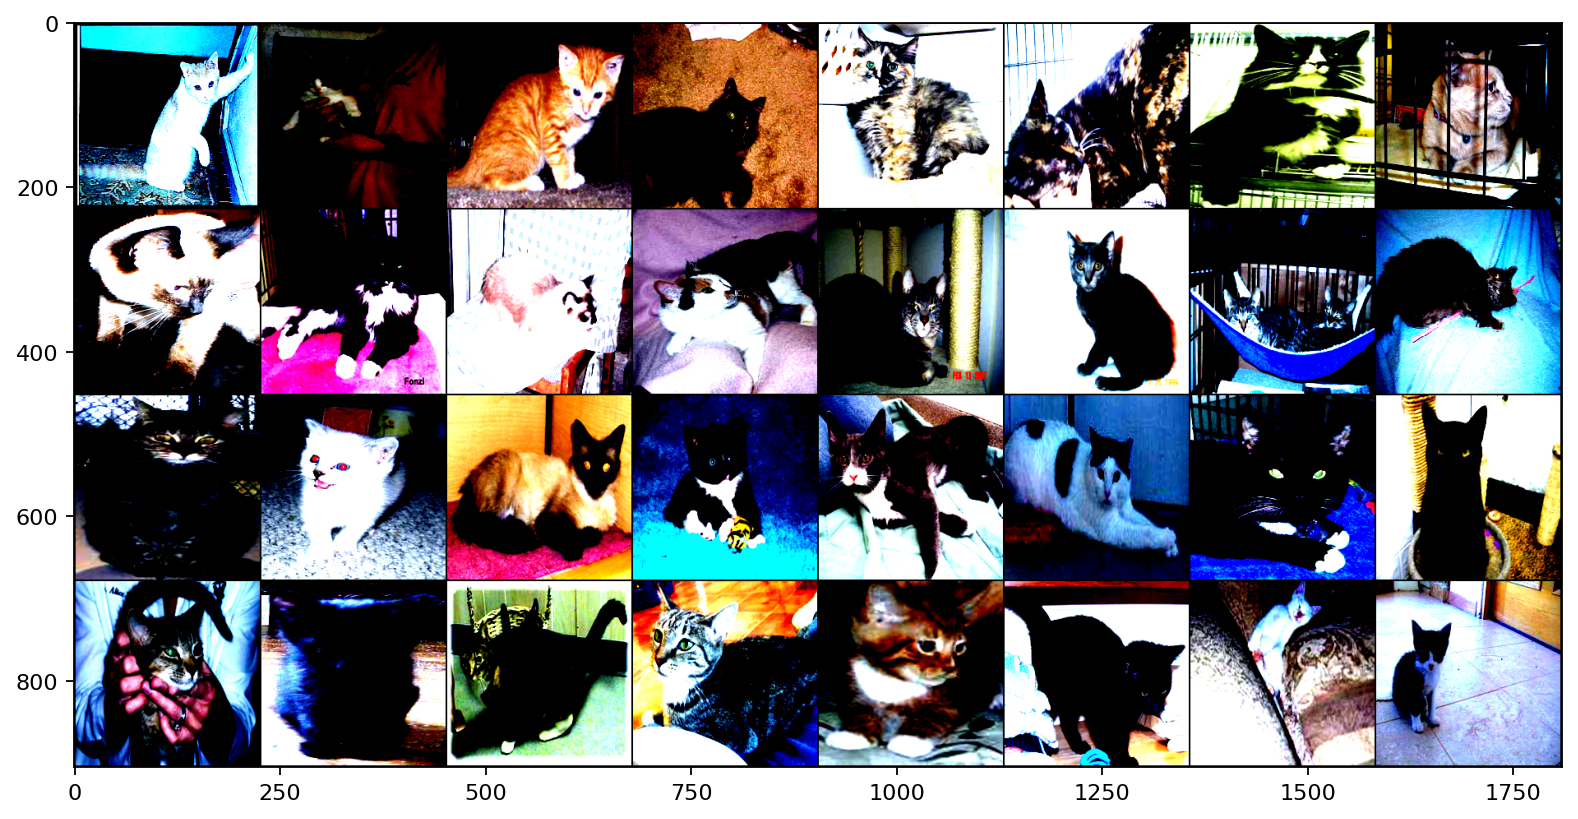

In [ ]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

# Obtener imagenes
data_iter = iter(test_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

## 5. El modelo

Construimos un modelo con dos capas convolucionales, un dropout y dos capas completamente conectadas para la clasificación.

* Imagen red: [https://i.imgur.com/wiP9IwZ.png](https://i.imgur.com/wiP9IwZ.png)
* Imagen Conv: https://i.imgur.com/E9GGJMJ.gif
* Imagen Pool: https://i.imgur.com/kSwID7J.png

## 6. Optimización

Seleccionamos cualquier algoritmo optimizador disponible en el paquete `torch.optim`. En general, los optimizadores son moficaciones del descenso del gradiente. Cambiando los parámetros del modelo, como los pesos, y añadiendo sesgo, el modelo puede ser optimizado. La **tasa de aprendizaje** decidirá cuán grandes deben ser los pasos para cambiar los parámetros.

* Calcular lo que un pequeño cambio en cada peso haría a la función de pérdida (seleccionando la dirección para alcanzar los mínimos).
* Ajustar cada peso en función de su gradiente (es decir, dar un pequeño paso en la dirección determinada).
* Continúe haciendo los pasos 1 y 2 hasta que la función de pérdida sea lo más baja posible.

Aquí, la estimación del momento adaptativo (*adaptive moment estimation* - Adam) se utiliza como un optimizador. Es una mezcla de **RMSprop** y **descenso de gradiente estocástico**.

### Configuración de Hyperparámetros

### Configuración del dispositivo

In [ ]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Optimizador

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = torch.nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torchvision.models as models 
from torchsummary import summary 

summary(model_ft.to(device), (3, 224, 224)) # Tamaño de imágenes soportado por ResNet

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 7. Entrenamiento con RestNet (_Transfer Learning_)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    all_loss = []
    all_acc = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              all_loss.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, all_loss

In [ ]:
model_ft, al = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0059 Acc: 0.9988
val Loss: 0.0324 Acc: 0.9870

Epoch 1/4
----------
train Loss: 0.0063 Acc: 0.9983
val Loss: 0.0346 Acc: 0.9850

Epoch 2/4
----------
train Loss: 0.0075 Acc: 0.9975
val Loss: 0.0318 Acc: 0.9875

Epoch 3/4
----------
train Loss: 0.0060 Acc: 0.9990
val Loss: 0.0353 Acc: 0.9865

Epoch 4/4
----------
train Loss: 0.0071 Acc: 0.9983
val Loss: 0.0323 Acc: 0.9870

Training complete in 5m 19s
Best val Acc: 0.987500


## 10.6 Graficamos los resultados

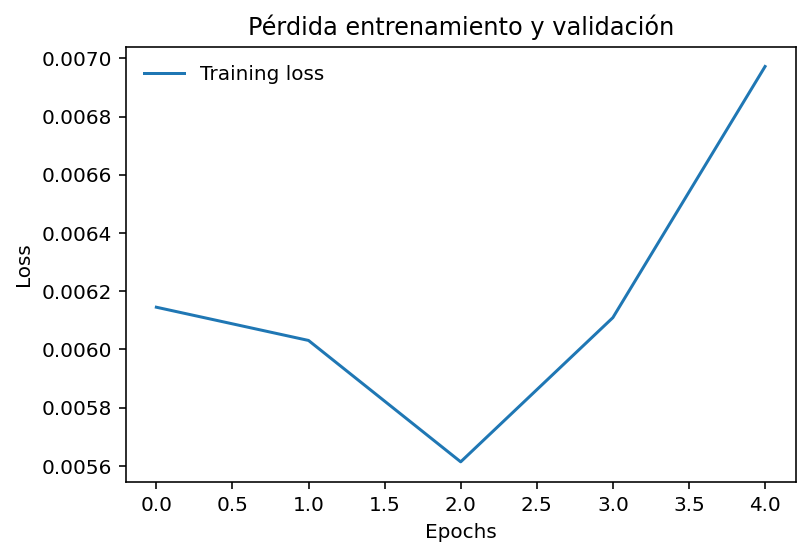

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(al, label='Training loss')
#plt.plot(ac, label='Validation loss')
plt.title('Pérdida entrenamiento y validación')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)